Log 변환
  - 왜곡된 분포도를 가진 데이터 세트를 비교적 정규 분포에 가깝게 변환해주는 Feature Engineering 방식

IQR (Inter Quantile Range:4분위)를 이용한 Outlier Removal
- 박스 플롯
  - 이상치 -> 최대값 이상, 즉 3/4 분위수에서 1.5 * IQR을 더한 지점 이상
  - 최대값 -> 3/4 분위수에서 1.5 * IQR 값을 더한 지점
  - 3/4 분위수, Q3(75%) -> 25%의 데이터가 이 값보다 큼
  - 2/4 분위수, Q2(50%) -> 중앙값으로 50%의 데이터가 이 값보다 큼(또는 작음)
  - 1/4 분위수, Q1(25%) -> 25%의 데이터가 이 값보다 작음
  - 최소값 : 1/4 분위수에서 1.5 * IQR 값을 뺀 지점
  - 이상치 : 최소값 이하, 즉 1/4 분위수에서 1.5 * IQR 을 뺀 지점 이하

언더 샘플링, 오버샘플링
- 레이블이 불균형한 분포를 가진 데이터 세트를 학습 시, 이상 레이블을 가지는 데이터 건수가 매우 적어 제대로 된 유형의 학습이 어려움
- 정상 레이블을 가지는 데이터 건수는 매우 많아 일방적으로 정상 레이블로 치우친 학습을 수행하여, 제대로 된 이상 데이터 검출이 어려움
- 오버/언더 샘플링을 통해 적절한 학습 데이터를 확보함
- SMOTE(Synthetic Minority Over-Sampling Technique)
  - 원본 데이터 -> K 최근접 이웃으로 데이터 신규 증식 -> 신규 증식하여 오버 샘플링 완료

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1KBarUeEgEVwJe6cNjOKfg2BWXCtcrkes' # url에서 file id만 copy/paste
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('creditcard.csv')

 데이터 가공 및 모델 학습/예측/평가

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [0]:
from sklearn.model_selection import train_test_split

# DataFrame 복사 후 Time 컬럼 삭제, 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

# 사전 데이터 가공 후 학습/테스트 데이터 세트 반환 함수
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df(df)
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [4]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [0]:
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    roc_auc = roc_auc_score(y_test, pred)
    print('---- confusion matrix ----')
    print(confusion)
    
    print('accuracy:{0:.4f}, precision:{1:.4f}, recall:{2:.4f}, f1:{3:.4f}, auc:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

get_clf_eval(y_test, lr_pred)

---- confusion matrix ----
[[85283    12]
 [   60    88]]
accuracy:0.9992, precision:0.8800, recall:0.5946, f1:0.7097, auc:0.7972


In [0]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  get_clf_eval(tgt_test, pred)

In [9]:
from lightgbm import LGBMClassifier

# boost_from_average가 True일때 레이블 값이 극 불균형 분포를 이룰 경우 recall 및 roc-auc 성능이 매우 저하됨.
# lightgbm 2.1.0 이상에서 발생
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

---- confusion matrix ----
[[85289     6]
 [   36   112]]
accuracy:0.9995, precision:0.9492, recall:0.7568, f1:0.8421, auc:0.8783


 데이터 분포도 변환 후 모델 학습/예측/평가

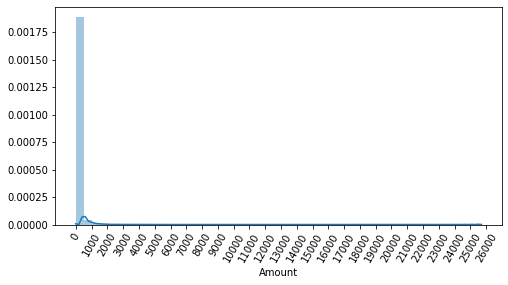

In [10]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [0]:
from sklearn.preprocessing import StandardScaler

# 정규분포 형태로 Amount 피처 값 변환 로직
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 컬럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [12]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
---- confusion matrix ----
[[85281    14]
 [   58    90]]
accuracy:0.9992, precision:0.8654, recall:0.6081, f1:0.7143, auc:0.8040
LightGBM 예측 성능
---- confusion matrix ----
[[85289     6]
 [   36   112]]
accuracy:0.9995, precision:0.9492, recall:0.7568, f1:0.8421, auc:0.8783


In [13]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # numpy의 log1p()를 이용하여 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
---- confusion matrix ----
[[85283    12]
 [   59    89]]
accuracy:0.9992, precision:0.8812, recall:0.6014, f1:0.7149, auc:0.8006
LightGBM 예측 성능
---- confusion matrix ----
[[85290     5]
 [   35   113]]
accuracy:0.9995, precision:0.9576, recall:0.7635, f1:0.8496, auc:0.8817


In [17]:
# log1p, expm1
import numpy as np

print(1e-1000 == 0.0)

print(np.log(1e-1000)) # -infinite
print(np.log(1e-1000 + 1))
print(np.log1p(1e-1000)) # log one plus

var_1 = np.log1p(100)
var_2 = np.expm1(var_1) # exp minus one
print(var_1, var_2)

True
-inf
0.0
0.0
4.61512051684126 100.00000000000003


이상치 데이터 제거 후 모델 학습/예측/평가

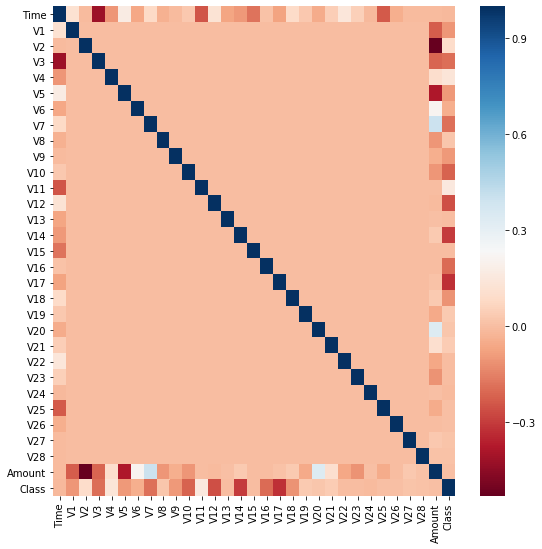

In [18]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr() # 상관도
sns.heatmap(corr, cmap='RdBu')

DataFrame에서 outlier에 해당하는 데이터를 필터링하기 위한 함수 생성. outlier 레코드의 index 반환

In [19]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR을 구하고, IQR * 1.5를 통해 최대값과 최소값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  # 최대값보다 크거나, 최소값보다 작은 값을 outlier로 설정하고 DataFrame index 반환
  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [25]:
np.percentile(card_df['V14'].values, 25)

-0.4255740124549935

In [20]:
# get_processed_df() 를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('로지스틱 회귀 예측 성능')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
---- confusion matrix ----
[[85281    14]
 [   48    98]]
accuracy:0.9993, precision:0.8750, recall:0.6712, f1:0.7597, auc:0.8355
LightGBM 예측 성능
---- confusion matrix ----
[[85291     4]
 [   25   121]]
accuracy:0.9997, precision:0.9680, recall:0.8288, f1:0.8930, auc:0.9144


SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
dtype: int64


In [22]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

---- confusion matrix ----
[[82937  2358]
 [   11   135]]
accuracy:0.9723, precision:0.0542, recall:0.9247, f1:0.1023, auc:0.9485


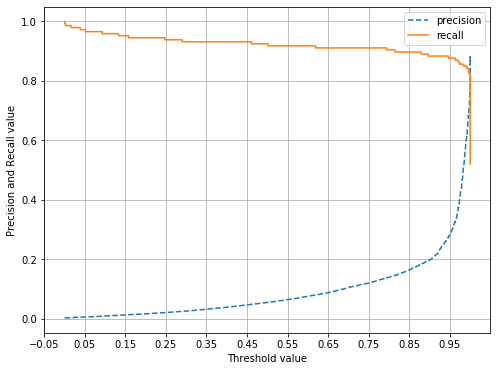

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold 값으로, y축은 정밀도, 재현율 값으로 Plot 수행. 정밀도=점선
  plt.figure(figsize=(8, 6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # x축, y축 label과 legend, grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [24]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

---- confusion matrix ----
[[85286     9]
 [   22   124]]
accuracy:0.9996, precision:0.9323, recall:0.8493, f1:0.8889, auc:0.9246
